In [2]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import json


%load_ext autoreload
%autoreload 2
from src.simulation import *
from src.analysis import *

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [10]:
# Load all metrics once
metrics_dict, epsilon_list, ranker_list = load_all_final_metrics('Experiments/Experiment_2_BIG/results')

Loaded data from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha0.1.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha0.1_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha0.5.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha0.5_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha1.0.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha1.0_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha2.0.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha2.0_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.0000_User_Success_alpha5.0.npz
Loaded config from: Experiments/Experiment_2_BIG/resu

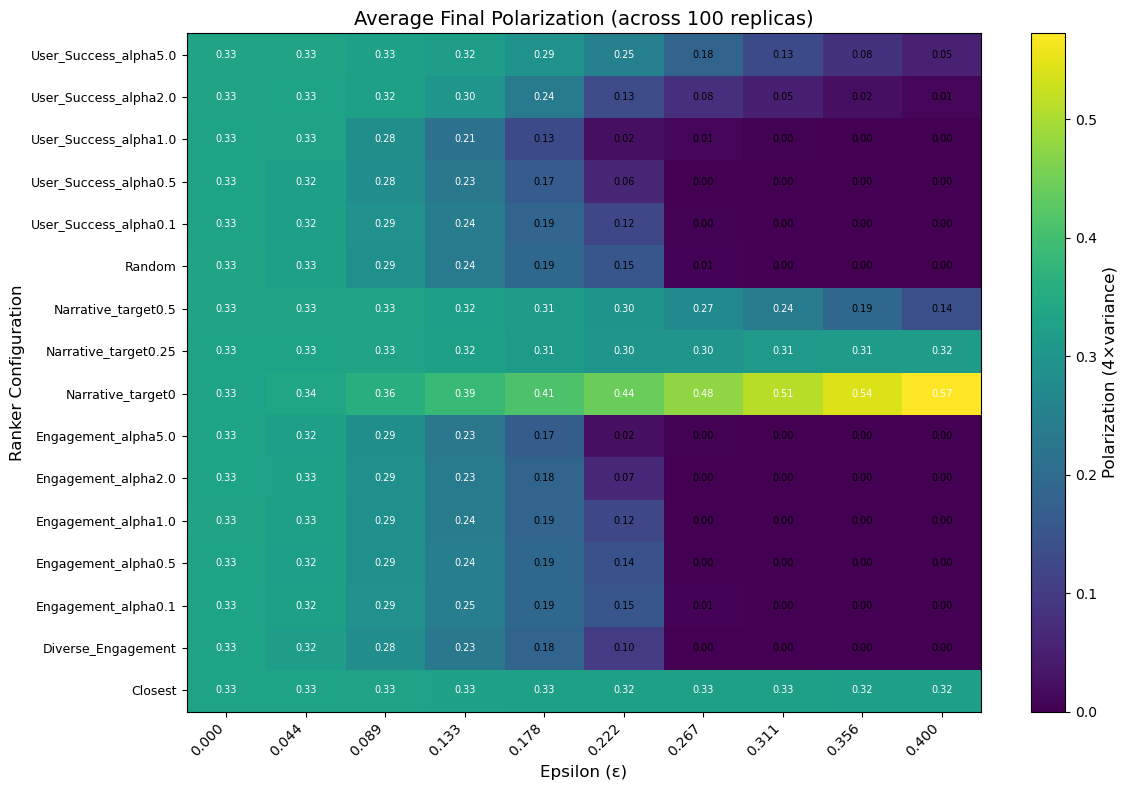

In [11]:
# Plot any metric
fig0 = plot_polarization_heatmap(metrics_dict, epsilon_list, ranker_list)
plt.show()


In [12]:
def plot_polarization_vs_random_heatmap(metrics_dict, epsilon_list, ranker_list):
    """
    Create heatmap showing polarization difference compared to Random ranker.
    Positive values = more polarized than Random, Negative = less polarized.
    
    Args:
        metrics_dict: dict containing metric arrays from load_all_final_metrics
        epsilon_list: list of epsilon values
        ranker_list: list of ranker configuration names
        
    Returns:
        fig: matplotlib figure
    """
    pol_array = metrics_dict['polarization']
    pol_mean = np.nanmean(pol_array, axis=0)
    
    n_epsilons = len(epsilon_list)
    n_rankers = len(ranker_list)
    
    # Find Random ranker
    random_idx = ranker_list.index('Random')
    random_pol = pol_mean[random_idx, :]
    
    # Compute difference: each ranker minus Random
    pol_diff = pol_mean - random_pol[None, :]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Use diverging colormap centered at 0
    vmax = np.nanmax(np.abs(pol_diff))
    im = ax.imshow(pol_diff, aspect='auto', origin='lower', cmap='RdBu_r', 
                   vmin=-vmax, vmax=vmax)
    
    ax.set_xticks(range(n_epsilons))
    ax.set_xticklabels([f'{eps:.3f}' for eps in epsilon_list], rotation=45, ha='right')
    
    ax.set_yticks(range(n_rankers))
    ax.set_yticklabels(ranker_list, fontsize=9)
    
    ax.set_xlabel('Epsilon (ε)', fontsize=12)
    ax.set_ylabel('Ranker Configuration', fontsize=12)
    ax.set_title('Polarization Difference vs Random (Ranker - Random)', fontsize=14)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Δ Polarization', fontsize=12)
    
    for i in range(n_rankers):
        for j in range(n_epsilons):
            if not np.isnan(pol_diff[i, j]):
                text_color = 'white' if np.abs(pol_diff[i, j]) > vmax * 0.5 else 'black'
                ax.text(j, i, f'{pol_diff[i, j]:+.2f}',
                       ha='center', va='center', 
                       color=text_color, fontsize=7)
    
    plt.tight_layout()
    return fig

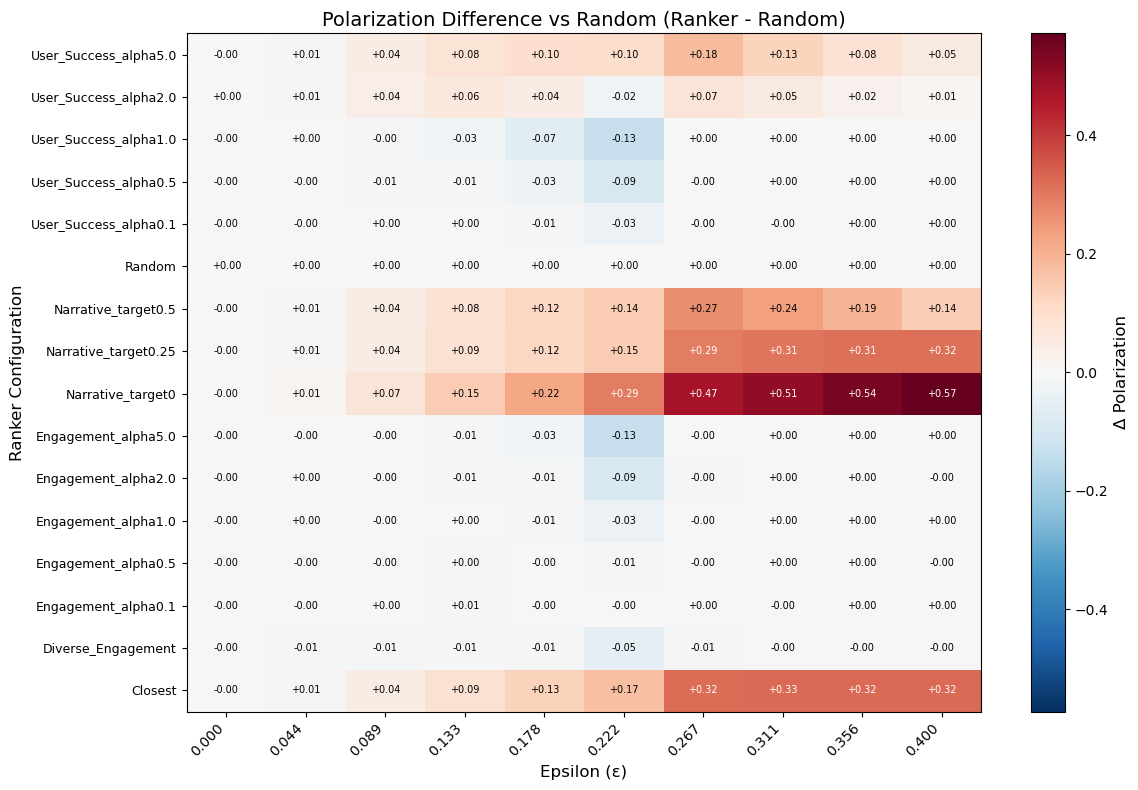

In [ ]:
fig  = plot_polarization_vs_random_heatmap(metrics_dict, epsilon_list, ranker_list)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob

def visualize_completion_status(exp_dir):
    """
    Visualize which simulations are completed vs missing.
    
    Args:
        exp_dir: path to experiment directory (e.g., 'Experiment_2_BIG')
    
    Returns:
        fig: matplotlib figure
    """
    # Load parameter grid
    with open(f'{exp_dir}/param_grid.json', 'r') as f:
        param_grid = json.load(f)
    
    # Generate all expected combinations
    grid = param_grid['grid']
    epsilons = grid['OD.epsilon']
    rankers = grid['Ranker.rule']
    
    # Build list of all expected filenames
    expected_files = []
    file_labels = []  # Human-readable labels
    
    for epsilon in epsilons:
        for ranker in rankers:
            if ranker == 'Engagement':
                for alpha in grid['Ranker.alpha']:
                    filename = f"eps{epsilon:.2f}_Engagement_alpha{alpha}.npz"
                    expected_files.append(filename)
                    file_labels.append(f"Eng α={alpha}")
            
            elif ranker == 'Narrative':
                for target in grid['Ranker.target_opinion']:
                    filename = f"eps{epsilon:.2f}_Narrative_target{target}.npz"
                    expected_files.append(filename)
                    file_labels.append(f"Narr t={target}")
            
            elif ranker == 'Evil':
                for target in grid['Ranker.target_opinion']:
                    filename = f"eps{epsilon:.2f}_Evil_target{target}.npz"
                    expected_files.append(filename)
                    file_labels.append(f"Evil t={target}")
            
            else:  # Random, Closest, Diverse_Engagement
                filename = f"eps{epsilon:.2f}_{ranker}.npz"
                expected_files.append(filename)
                file_labels.append(ranker)
    
    # Check which files exist
    results_dir = f'{exp_dir}/results'
    existing_files = set([os.path.basename(f) for f in glob.glob(f'{results_dir}/*.npz')])
    
    # Create completion matrix
    n_eps = len(epsilons)
    n_configs = len(expected_files) // n_eps
    
    completion = np.zeros((n_eps, n_configs))
    
    for i, filename in enumerate(expected_files):
        eps_idx = i // n_configs
        config_idx = i % n_configs
        completion[eps_idx, config_idx] = 1 if filename in existing_files else 0
    
    # Visualization
    fig, ax = plt.subplots(figsize=(16, 8))
    
    im = ax.imshow(completion, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Labels
    ax.set_xticks(range(n_configs))
    ax.set_xticklabels(file_labels[:n_configs], rotation=45, ha='right', fontsize=8)
    
    ax.set_yticks(range(n_eps))
    ax.set_yticklabels([f'ε={eps:.3f}' for eps in epsilons])
    
    ax.set_xlabel('Ranker Configuration')
    ax.set_ylabel('Epsilon')
    ax.set_title(f'Simulation Completion Status ({int(completion.sum())}/{len(expected_files)} complete)')
    
    # Add text annotations
    for i in range(n_eps):
        for j in range(n_configs):
            text = 'âœ"' if completion[i, j] == 1 else 'âœ—'
            color = 'white' if completion[i, j] == 1 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=color, fontsize=10)
    
    plt.colorbar(im, ax=ax, label='Completed')
    plt.tight_layout()
    
    # Print summary
    print(f"\nCompletion Summary:")
    print(f"{'='*50}")
    print(f"Total jobs: {len(expected_files)}")
    print(f"Completed: {int(completion.sum())}")
    print(f"Missing: {len(expected_files) - int(completion.sum())}")
    print(f"Progress: {100*completion.sum()/len(expected_files):.1f}%")
    
    # List missing files
    missing = [f for f in expected_files if f not in existing_files]
    if missing:
        print(f"\nMissing files ({len(missing)}):")
        for f in missing[:10]:  # Show first 10
            print(f"  - {f}")
        if len(missing) > 10:
            print(f"  ... and {len(missing)-10} more")
    
    return fig



Completion Summary:
Total jobs: 140
Completed: 110
Missing: 30
Progress: 78.6%

Missing files (30):
  - eps0.00_Evil_target0.npz
  - eps0.00_Evil_target0.25.npz
  - eps0.00_Evil_target0.5.npz
  - eps0.04_Evil_target0.npz
  - eps0.04_Evil_target0.25.npz
  - eps0.04_Evil_target0.5.npz
  - eps0.09_Evil_target0.npz
  - eps0.09_Evil_target0.25.npz
  - eps0.09_Evil_target0.5.npz
  - eps0.13_Evil_target0.npz
  ... and 20 more


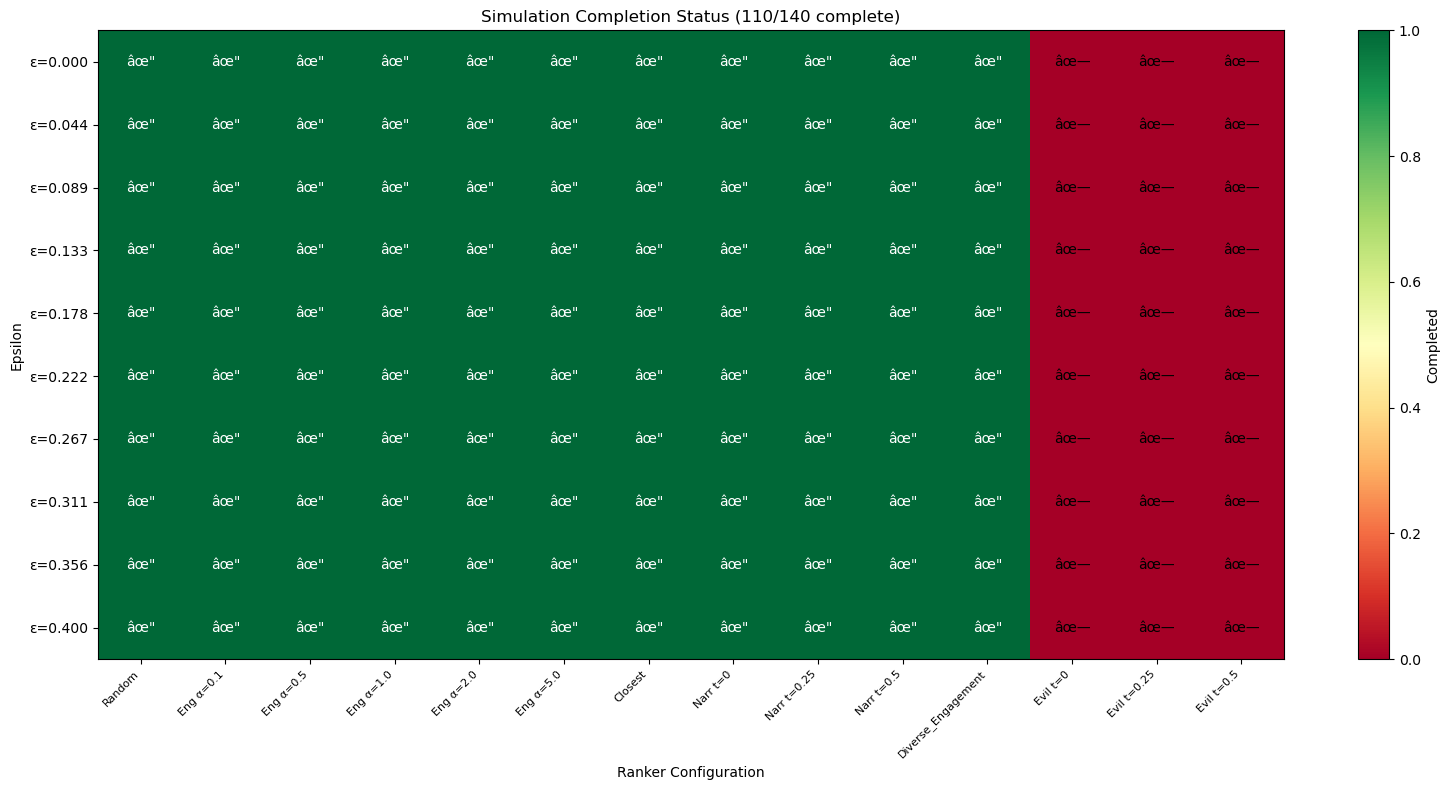

In [3]:
fig = visualize_completion_status('Experiments/Experiment_2_BIG')
# Usage:
# fig = visualize_completion_status('Experiment_2_BIG')
# plt.show()

In [8]:
import glob
import os
import numpy as np
from src.analysis import load_results

# Set experiment directory
exp_dir = 'Experiments/Experiment_2_BIG'
results_dir = f'{exp_dir}/results'

# Dictionary to store final polarization values
# Key: (epsilon, ranker, optional_params)
# Value: array of shape (n_replicas,) with final polarization values
final_polarization = {}
final_homophily = {}
final_success = {}
final_filter_bubble = {}
final_reach = {}

# Also track unique epsilons and ranker configs
epsilon_values = set()
ranker_configs = set()

for filepath in glob.glob(f'{results_dir}/*.npz'):
    base_path = filepath[:-4]
    data, config = load_results(base_path)
    
    epsilon = config['OD']['epsilon']
    ranker = config['Ranker']['rule']
    
    epsilon_values.add(epsilon)
    
    # Create key based on ranker type
    if ranker == 'Engagement':
        alpha = config['Ranker']['alpha']
        key = (epsilon, f'{ranker}_alpha{alpha}')
        ranker_configs.add(f'{ranker}_alpha{alpha}')
    elif ranker in ['Narrative', 'Evil']:
        target = config['Ranker']['target_opinion']
        key = (epsilon, f'{ranker}_target{target}')
        ranker_configs.add(f'{ranker}_target{target}')
    else:
        key = (epsilon, ranker)
        ranker_configs.add(ranker)
    
    # Extract final polarization (last timestep, scaled by 4)
    final_pol = data['pol'][:, -1] * 4  # Shape: (n_replicas,)
    final_hom = data['homophily'][:, -1]  # Shape: (n_replicas,)
    final_succ = data['gini_success']  # Shape: (n_replicas,)
    final_fb = data['filter_bubble'][:, -1]  # Shape: (n_replicas,)
    final_reach_vals = data['gini_reach'][:, -1]  # Shape: (n_replicas,)
    

    final_polarization[key] = final_pol
    final_homophily[key] = final_hom
    final_success[key] = final_succ
    final_filter_bubble[key] = final_fb
    final_reach[key] = final_reach_vals

# Sort for consistent ordering
epsilon_list = sorted(epsilon_values)
ranker_list = sorted(ranker_configs)

# Create 3D array: (n_replicas, n_rankers, n_epsilons)
n_replicas = 100
n_epsilons = len(epsilon_list)
n_rankers = len(ranker_list)

pol_array = np.full((n_replicas, n_rankers, n_epsilons), np.nan)
hom_array = np.full((n_replicas, n_rankers, n_epsilons), np.nan)
success_array = np.full((n_replicas, n_rankers, n_epsilons), np.nan)
filter_bubble_array = np.full((n_replicas, n_rankers, n_epsilons), np.nan)
reach_array = np.full((n_replicas, n_rankers, n_epsilons), np.nan)







for i_eps, eps in enumerate(epsilon_list):
    for i_rank, rank in enumerate(ranker_list):
        key = (eps, rank)
        if key in final_polarization:
            pol_array[:, i_rank, i_eps] = final_polarization[key]

print(f"\nArray shape: {pol_array.shape}")
print(f"Missing entries: {np.isnan(pol_array).sum()} / {pol_array.size}")

# Print epsilon values
print("\nEpsilon values:")
for i, eps in enumerate(epsilon_list):
    print(f"  {i}: {eps:.4f}")

# Print ranker configs
print("\nRanker configs:")
for i, rank in enumerate(ranker_list):
    print(f"  {i}: {rank}")

Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Closest.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Closest_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0_config.json
Contains 100 repli

In [6]:
epsilons = [0.0     , 0.0444, 0.0889, 0.1333, 0.1778, 0.2222, 0.2667, 0.3111, 0.3556, 0.4   ]
epsilon = epsilons[4]

In [6]:
# Get all replicas for Random ranker at epsilon=0.2
eps_idx = epsilon_list.index(epsilon)
rank_idx = ranker_list.index('Random')
random_pol = pol_array[:, rank_idx, eps_idx]

print(f"Random ranker at ε={epsilon}: mean={random_pol.mean():.3f}, std={random_pol.std():.3f}")
# Get mean across replicas for all configs
pol_mean = np.nanmean(pol_array, axis=0)  # Shape: (n_rankers, n_epsilons)

Random ranker at ε=0.4: mean=0.000, std=0.000


Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Closest.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Closest_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0_config.json
Contains 100 repli

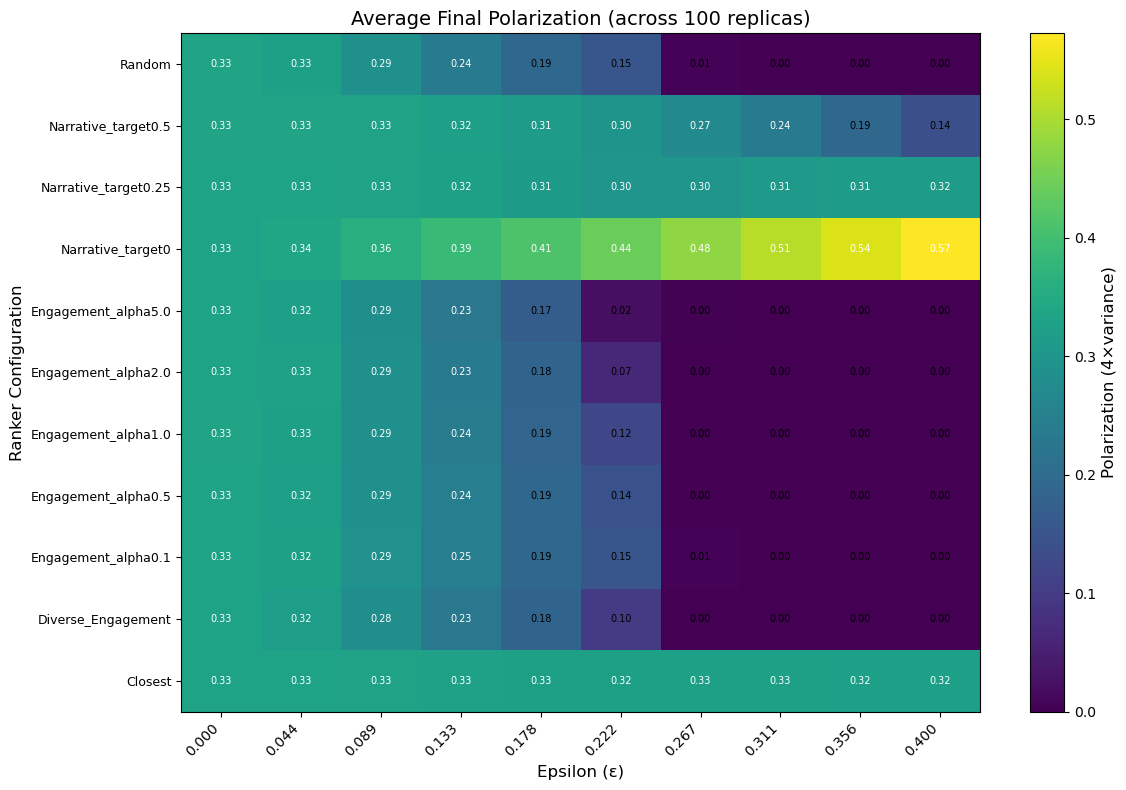

In [14]:
fig = plot_polarization_simple()

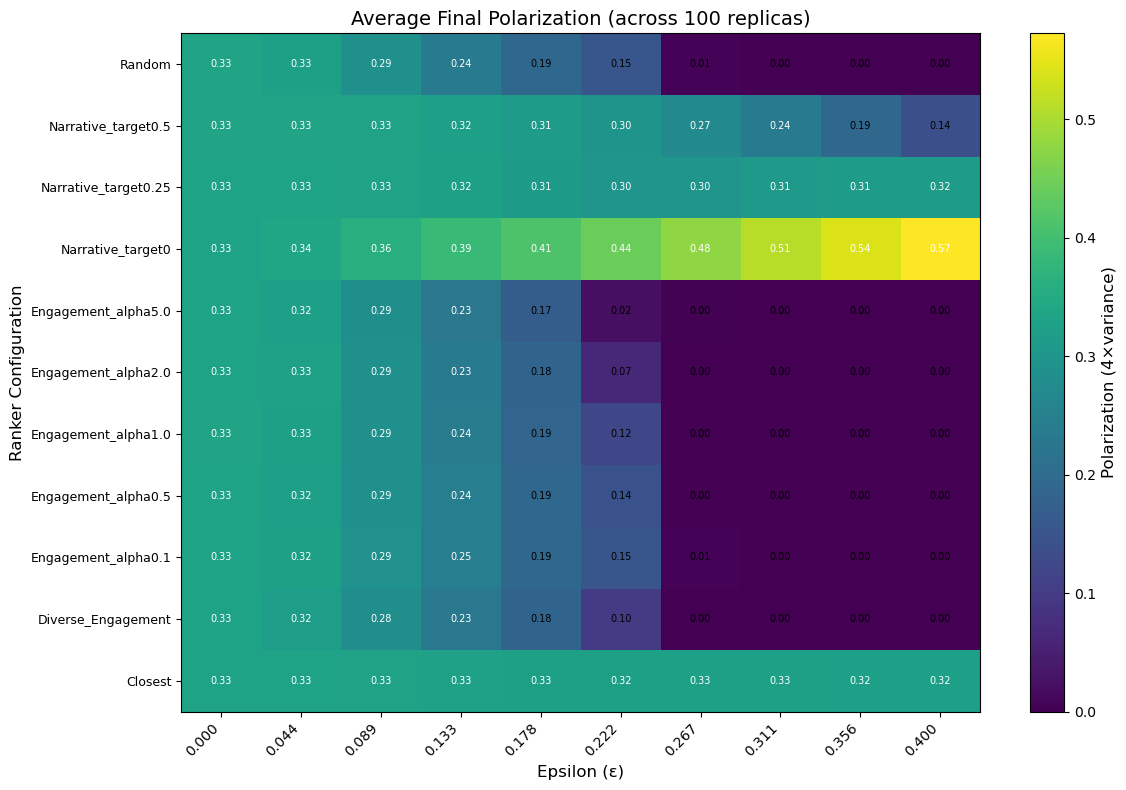

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean polarization across replicas
pol_mean = np.nanmean(pol_array, axis=0)  # Shape: (n_rankers, n_epsilons)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(pol_mean, aspect='auto', origin='lower', cmap='viridis')

# Set ticks and labels
ax.set_xticks(range(n_epsilons))
ax.set_xticklabels([f'{eps:.3f}' for eps in epsilon_list], rotation=45, ha='right')

ax.set_yticks(range(n_rankers))
ax.set_yticklabels(ranker_list, fontsize=9)

ax.set_xlabel('Epsilon (ε)', fontsize=12)
ax.set_ylabel('Ranker Configuration', fontsize=12)
ax.set_title('Average Final Polarization (across 100 replicas)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Polarization (4×variance)', fontsize=12)

# Optional: Add text annotations with values
for i in range(n_rankers):
    for j in range(n_epsilons):
        if not np.isnan(pol_mean[i, j]):
            text = ax.text(j, i, f'{pol_mean[i, j]:.2f}',
                          ha='center', va='center', 
                          color='white' if pol_mean[i, j] > pol_mean[~np.isnan(pol_mean)].mean() else 'black',
                          fontsize=7)

plt.tight_layout()
plt.show()

In [11]:
hom_array

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

C:\Users\nel_t\AppData\Local\Temp\ipykernel_19252\716754486.py:5: RuntimeWarning: Mean of empty slice
  pol_mean = np.nanmean(hom_array, axis=0)  # Shape: (n_rankers, n_epsilons)


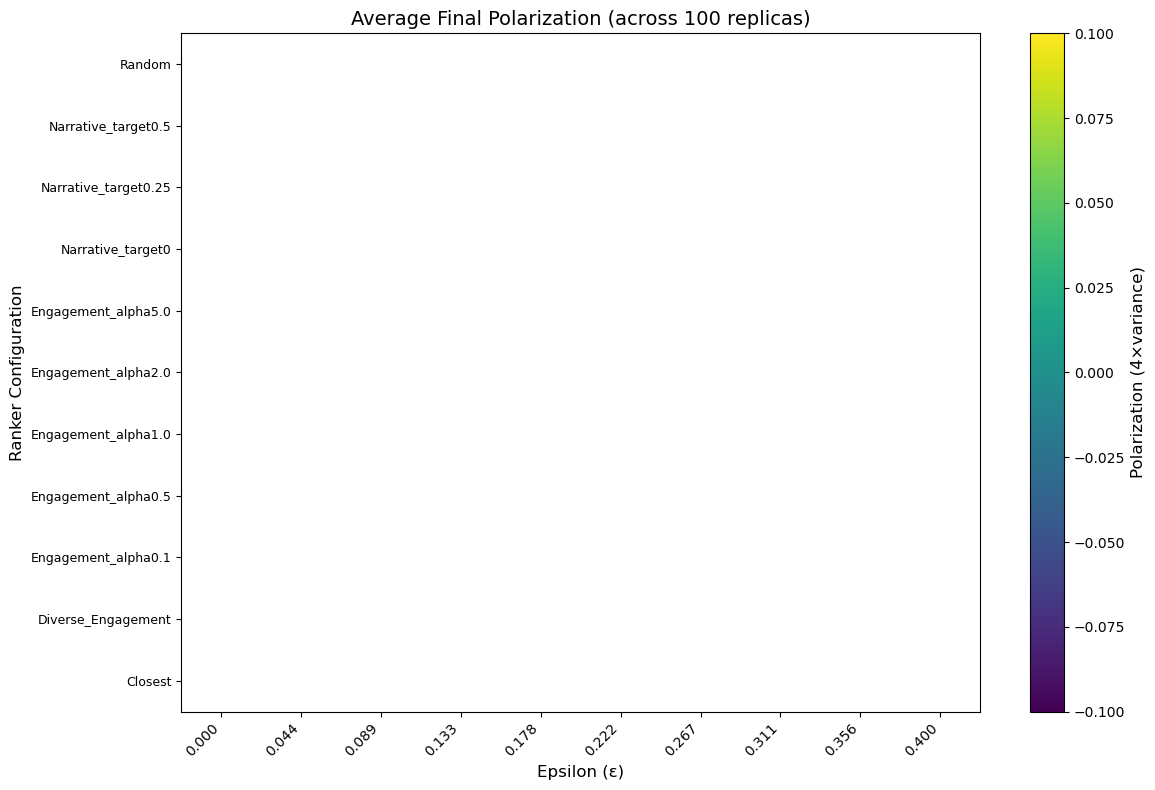

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean polarization across replicas
pol_mean = np.nanmean(hom_array, axis=0)  # Shape: (n_rankers, n_epsilons)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(pol_mean, aspect='auto', origin='lower', cmap='viridis')

# Set ticks and labels
ax.set_xticks(range(n_epsilons))
ax.set_xticklabels([f'{eps:.3f}' for eps in epsilon_list], rotation=45, ha='right')

ax.set_yticks(range(n_rankers))
ax.set_yticklabels(ranker_list, fontsize=9)

ax.set_xlabel('Epsilon (ε)', fontsize=12)
ax.set_ylabel('Ranker Configuration', fontsize=12)
ax.set_title('Average Final Polarization (across 100 replicas)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Polarization (4×variance)', fontsize=12)

# Optional: Add text annotations with values
for i in range(n_rankers):
    for j in range(n_epsilons):
        if not np.isnan(pol_mean[i, j]):
            text = ax.text(j, i, f'{pol_mean[i, j]:.2f}',
                          ha='center', va='center', 
                          color='white' if pol_mean[i, j] > pol_mean[~np.isnan(pol_mean)].mean() else 'black',
                          fontsize=7)

plt.tight_layout()
plt.show()

Loaded data from: Experiments/Experiment_2_BIG/results/eps0.00_Narrative_target0.npz
Loaded config from: Experiments/Experiment_2_BIG/results/eps0.00_Narrative_target0_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results/eps0.13_Narrative_target0.npz
Loaded config from: Experiments/Experiment_2_BIG/results/eps0.13_Narrative_target0_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results/eps0.27_Narrative_target0.npz
Loaded config from: Experiments/Experiment_2_BIG/results/eps0.27_Narrative_target0_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results/eps0.40_Narrative_target0.npz
Loaded config from: Experiments/Experiment_2_BIG/results/eps0.40_Narrative_target0_config.json
Contains 100 replicas


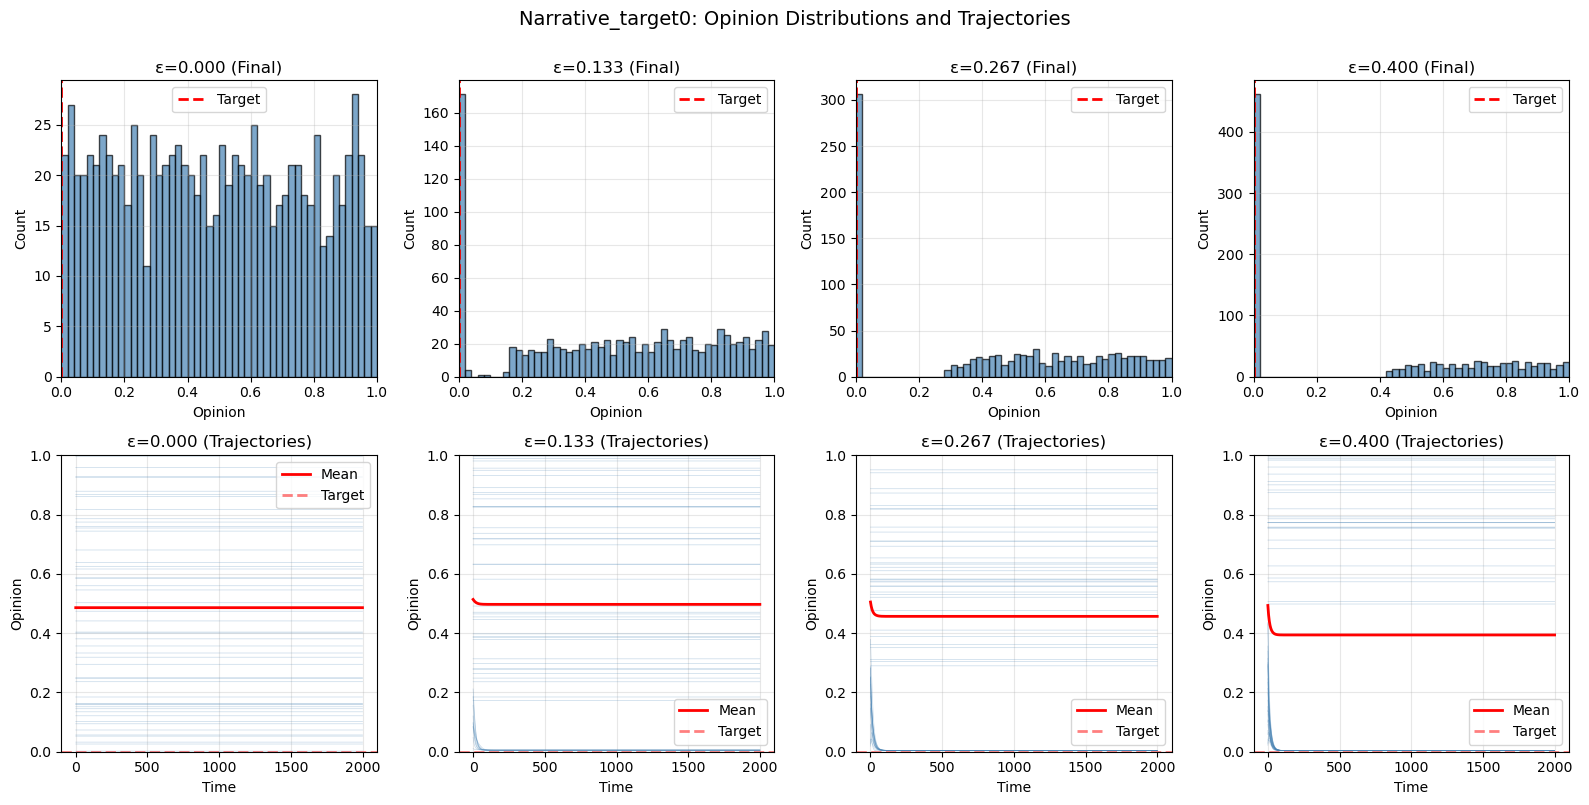

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from src.analysis import load_results

# Load Narrative_target0 results for different epsilons
exp_dir = 'Experiments/Experiment_2_BIG'
results_dir = f'{exp_dir}/results'

# Pick a few epsilon values to compare
epsilons_to_plot = [0.0, 0.133, 0.267, 0.4]
n_eps = len(epsilons_to_plot)

fig, axes = plt.subplots(2, n_eps, figsize=(16, 8))

for col, target_eps in enumerate(epsilons_to_plot):
    # Load the Narrative_target0 result for this epsilon
    filename = f"{results_dir}/eps{target_eps:.2f}_Narrative_target0"
    data, config = load_results(filename)
    
    # Extract opinions: shape (5 replicas, 2000 steps, 1000 users)
    opinions = data['opinions']
    
    # Get first replica for trajectory visualization
    first_replica_opinions = opinions[0]  # Shape: (2000, 1000)
    
    # Top row: Final opinion distribution (histogram)
    ax_hist = axes[0, col]
    final_opinions = first_replica_opinions[-1, :]  # Last timestep, all users
    
    ax_hist.hist(final_opinions, bins=50, range=(0, 1), alpha=0.7, color='steelblue', edgecolor='black')
    ax_hist.axvline(0.0, color='red', linestyle='--', linewidth=2, label='Target')
    ax_hist.set_xlabel('Opinion')
    ax_hist.set_ylabel('Count')
    ax_hist.set_title(f'ε={target_eps:.3f} (Final)')
    ax_hist.set_xlim(0, 1)
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)
    
    # Bottom row: Opinion trajectories (sample of users)
    ax_traj = axes[1, col]
    time = np.arange(2000)
    
    # Plot sample of user trajectories
    n_sample = 50  # Show 50 random users
    sample_indices = np.random.choice(1000, n_sample, replace=False)
    
    for user_idx in sample_indices:
        ax_traj.plot(time, first_replica_opinions[:, user_idx], alpha=0.3, linewidth=0.5, color='steelblue')
    
    # Plot mean trajectory
    mean_trajectory = first_replica_opinions.mean(axis=1)
    ax_traj.plot(time, mean_trajectory, color='red', linewidth=2, label='Mean')
    ax_traj.axhline(0.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Target')
    
    ax_traj.set_xlabel('Time')
    ax_traj.set_ylabel('Opinion')
    ax_traj.set_title(f'ε={target_eps:.3f} (Trajectories)')
    ax_traj.set_ylim(0, 1)
    ax_traj.legend()
    ax_traj.grid(True, alpha=0.3)

fig.suptitle('Narrative_target0: Opinion Distributions and Trajectories', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
from src.analysis import load_results, plot_ranker_comparison, plot_ranker_comparison_light

In [ ]:
import glob
import os
from src.analysis import load_results, plot_ranker_comparison, plot_ranker_comparison_light

# Set experiment directory
exp_dir = 'Experiments/Experiment_2_BIG'  # Adjust path as needed
results_dir = f'{exp_dir}/results'

# Load all results
all_results = {}

for filepath in glob.glob(f'{results_dir}/*.npz'):
    # Remove .npz extension to get base filepath
    base_path = filepath[:-4]
    
    # Load data and config
    data, config = load_results(base_path)
    
    # Extract epsilon and ranker for organization
    epsilon = config['OD']['epsilon']
    ranker = config['Ranker']['rule']
    
    # Create key for lookup
    key = (epsilon, ranker)
    
    # Handle rankers with additional parameters
    if ranker == 'Engagement':
        alpha = config['Ranker']['alpha']
        key = (epsilon, ranker, alpha)
    elif ranker in ['Narrative', 'Evil']:
        target = config['Ranker']['target_opinion']
        key = (epsilon, ranker, target)
    
    all_results[key] = (data, config)

print(f"Loaded {len(all_results)} result files")

Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Closest.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Closest_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Diverse_Engagement_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.1_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha0.5_config.json
Contains 100 replicas
Loaded data from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0.npz
Loaded config from: Experiments/Experiment_2_BIG/results\eps0.00_Engagement_alpha1.0_config.json
Contains 100 repli

In [26]:
epsilons = [0.0     , 0.0444, 0.0889, 0.1333, 0.1778, 0.2222, 0.2667, 0.3111, 0.3556, 0.4   ]
colors = ['#000',
 '#d95f02',
 '#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b',
 '#238443', '#78c679', '#d9f0a3', '#e7298a'
]


Found 11 rankers for epsilon=0.0


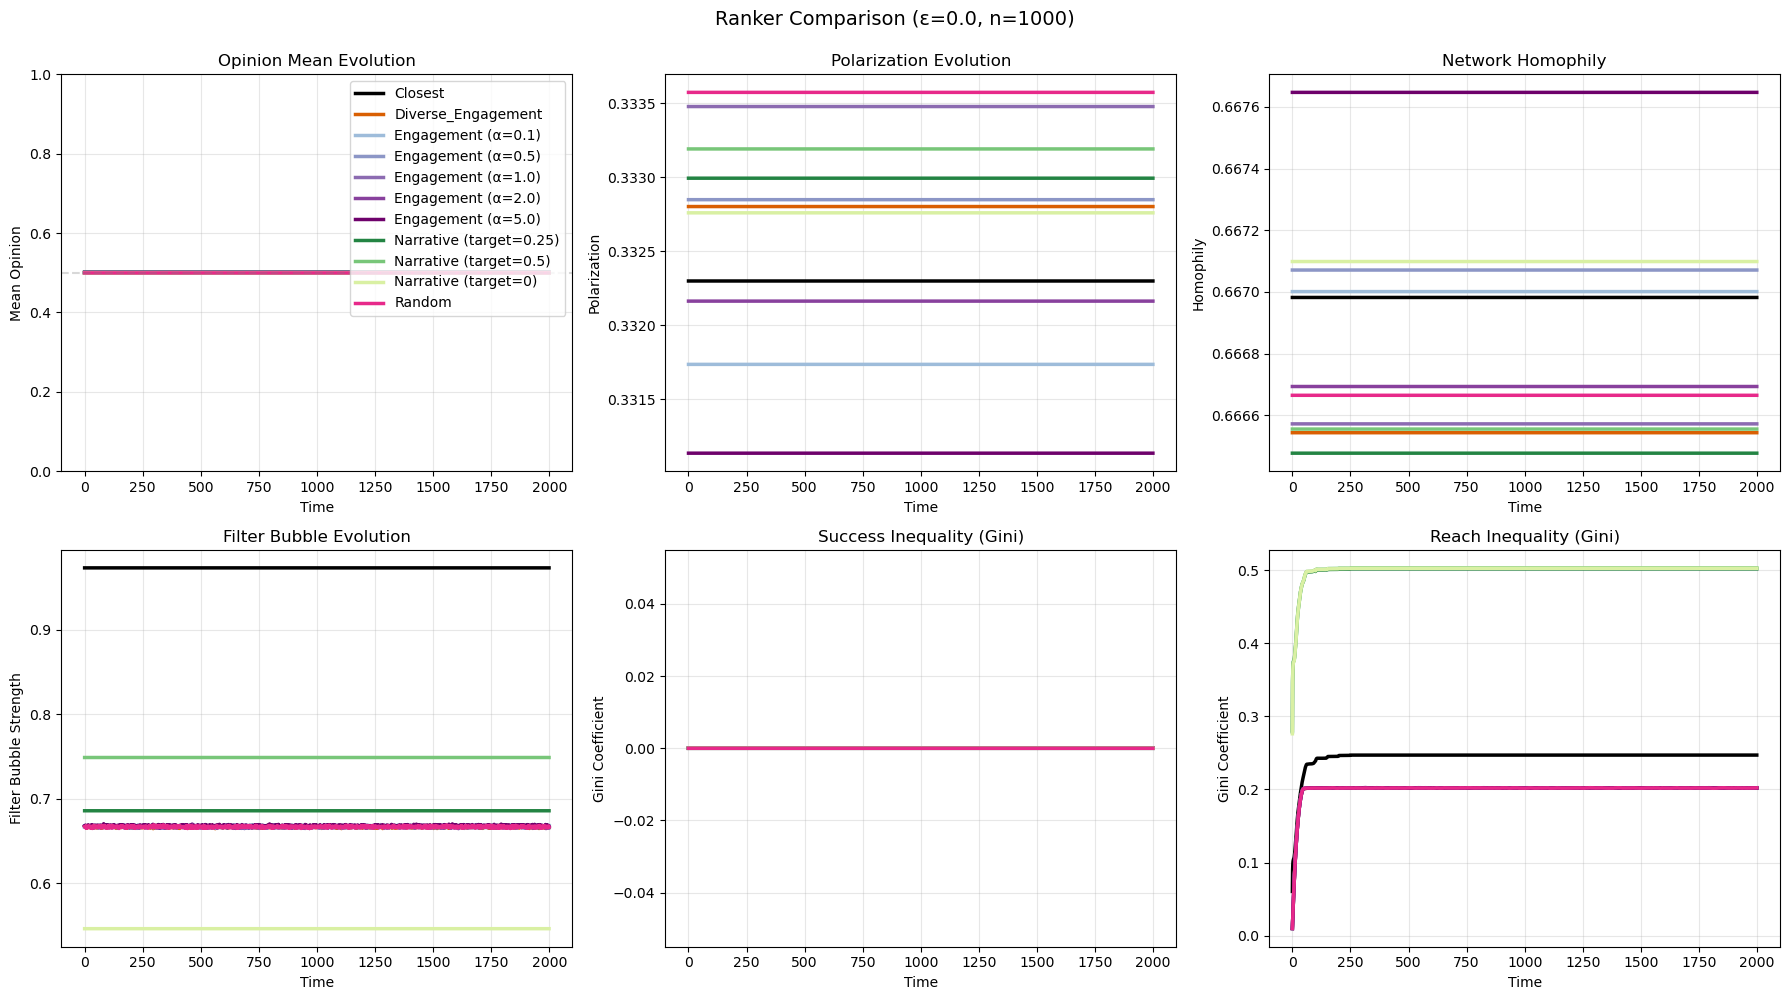


Found 11 rankers for epsilon=0.0444


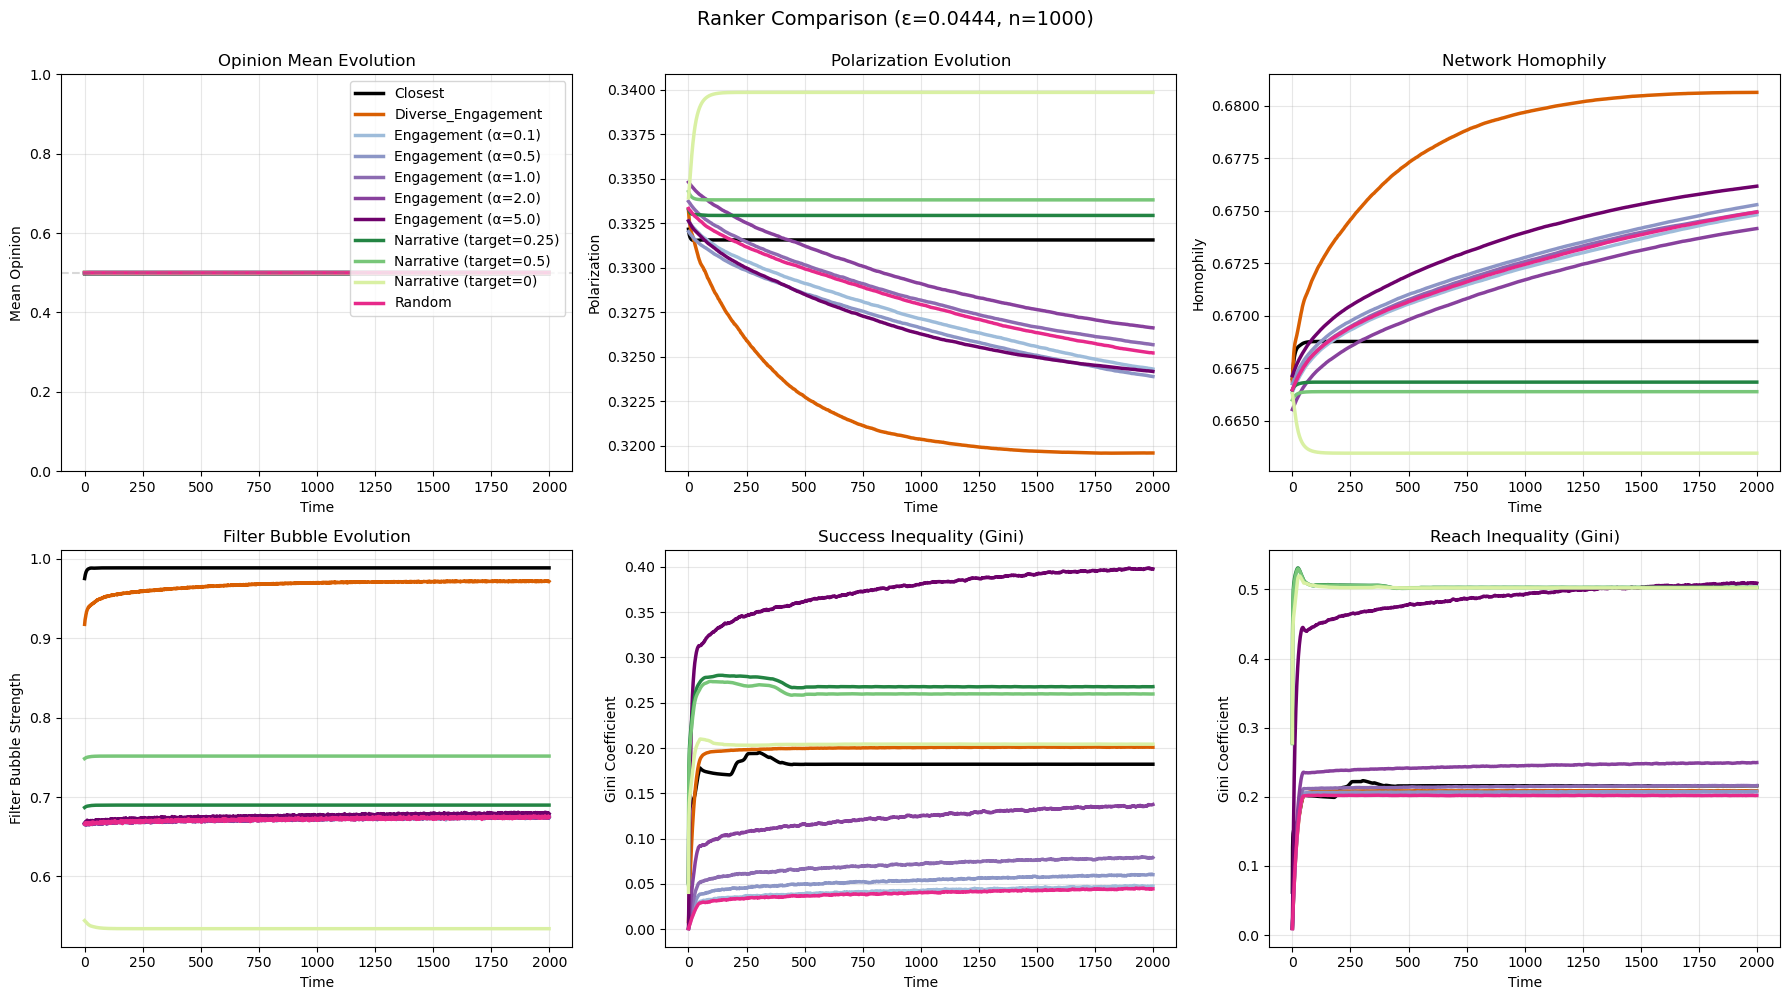


Found 11 rankers for epsilon=0.0889


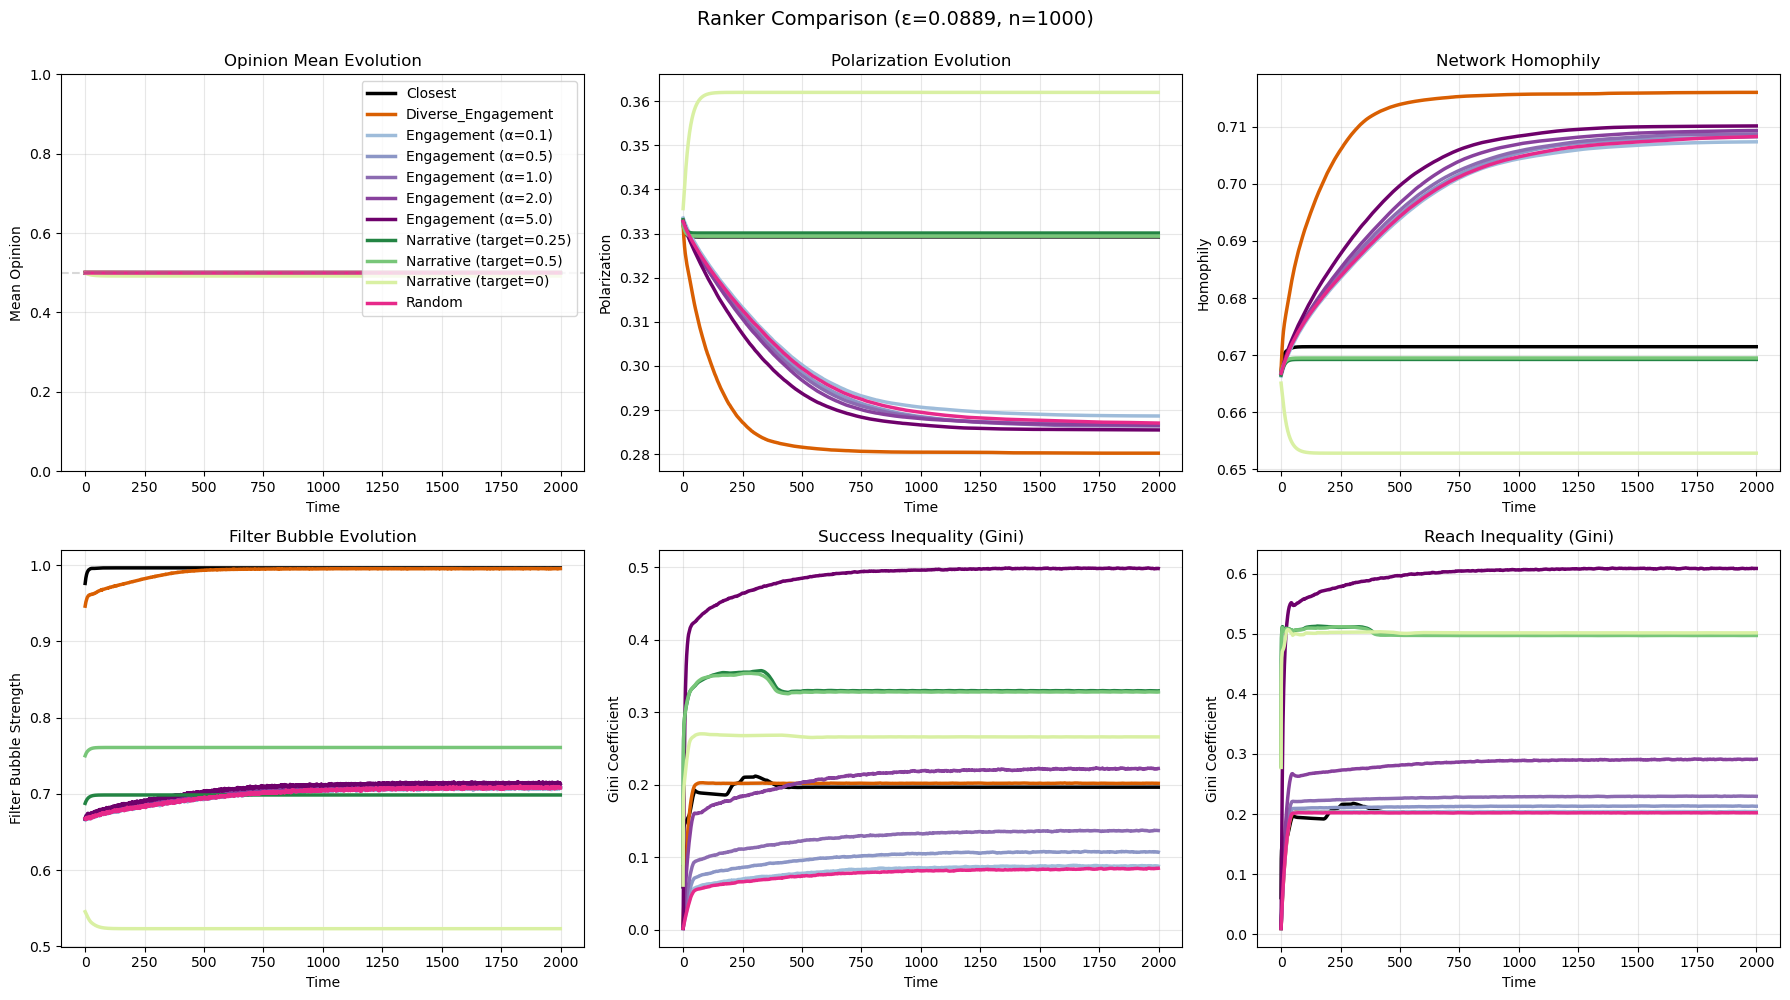


Found 11 rankers for epsilon=0.1333


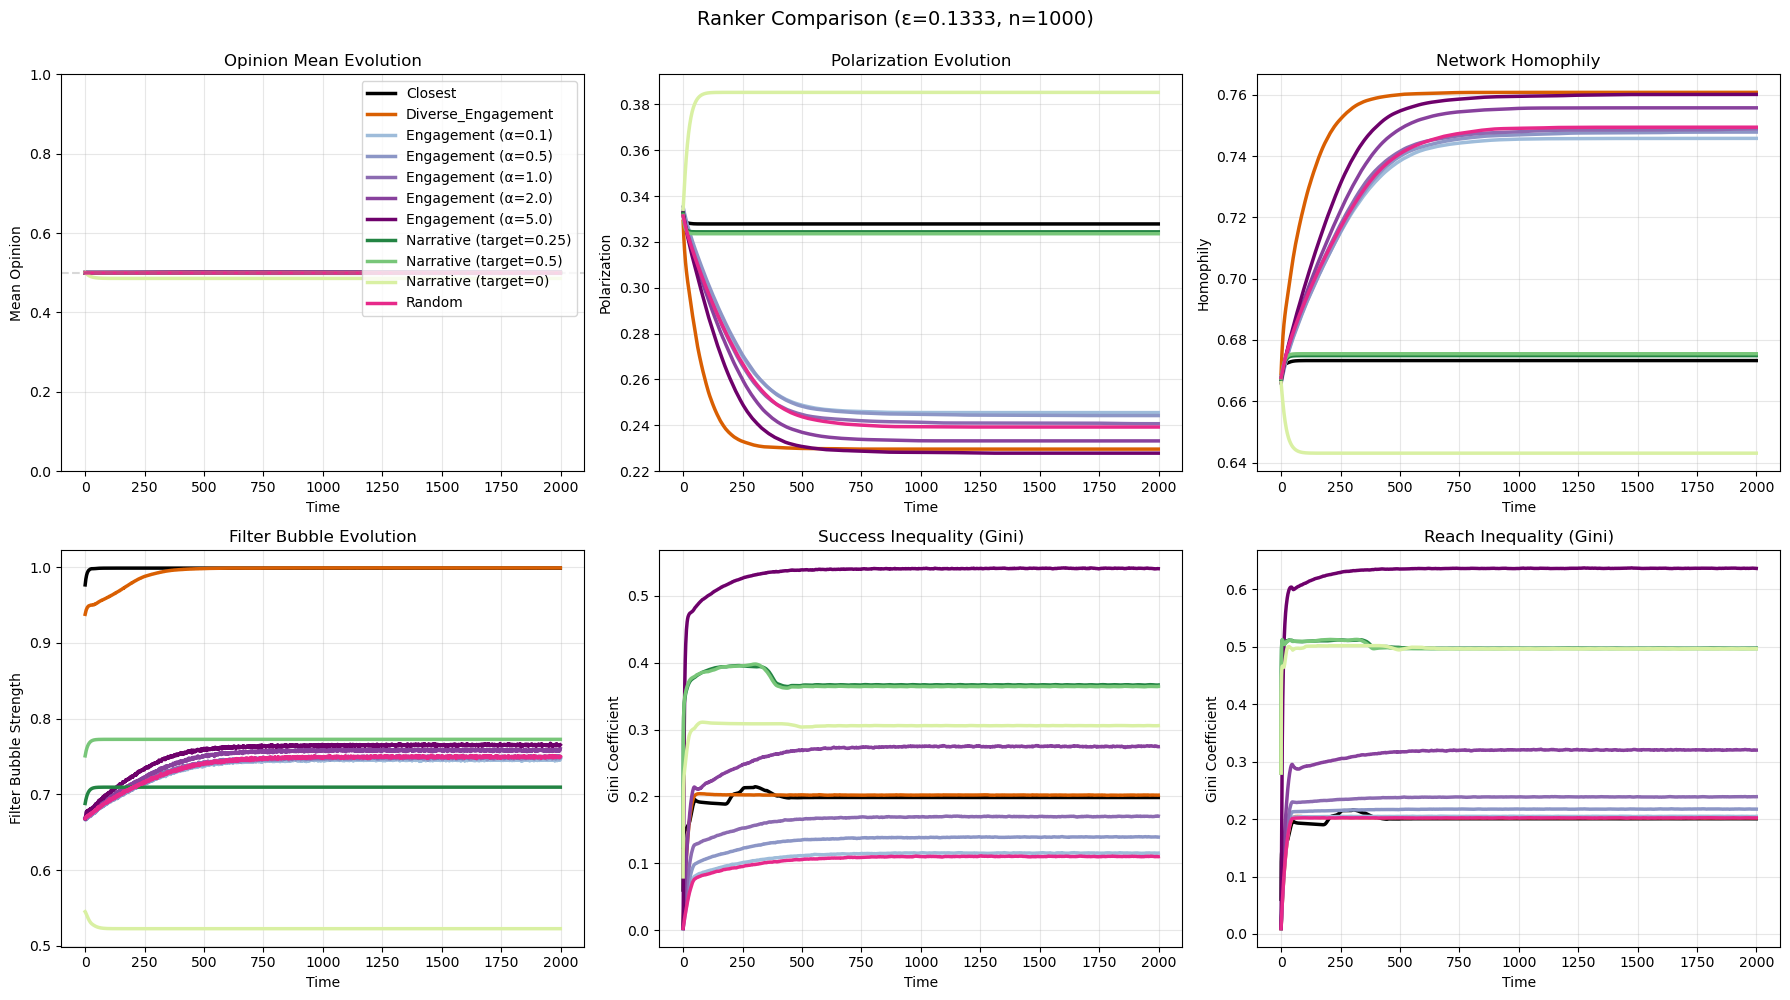


Found 11 rankers for epsilon=0.1778


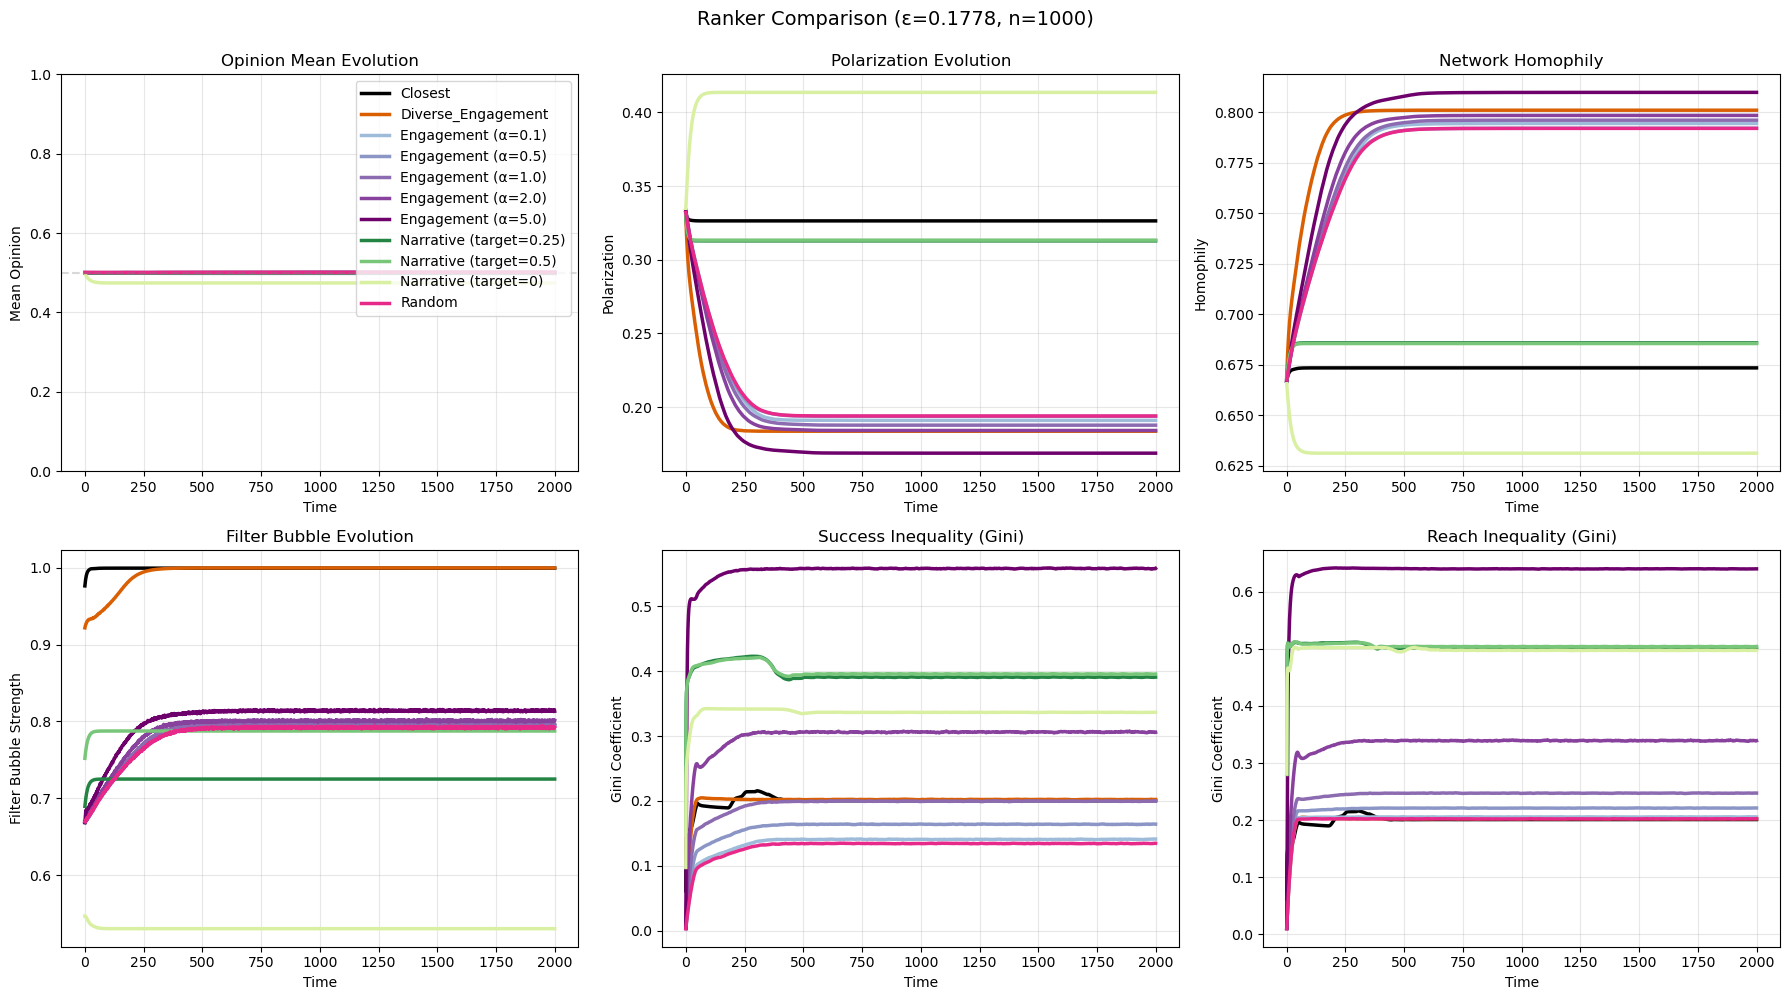


Found 11 rankers for epsilon=0.2222


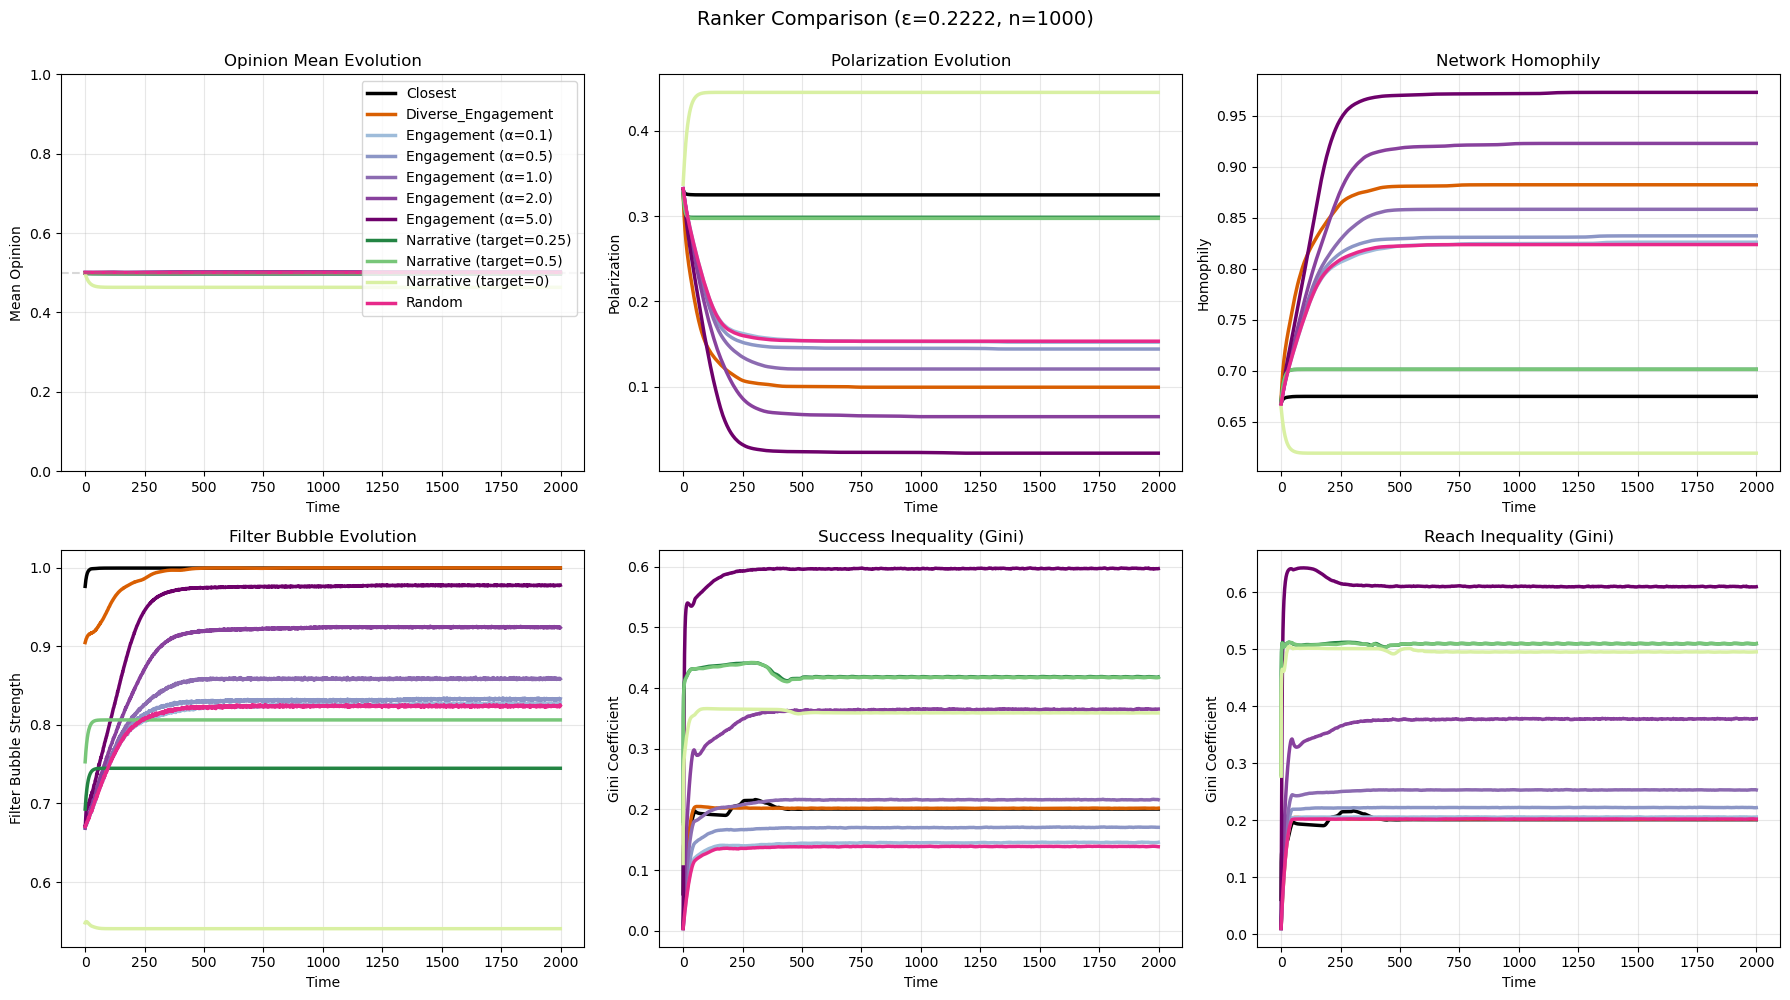


Found 11 rankers for epsilon=0.2667


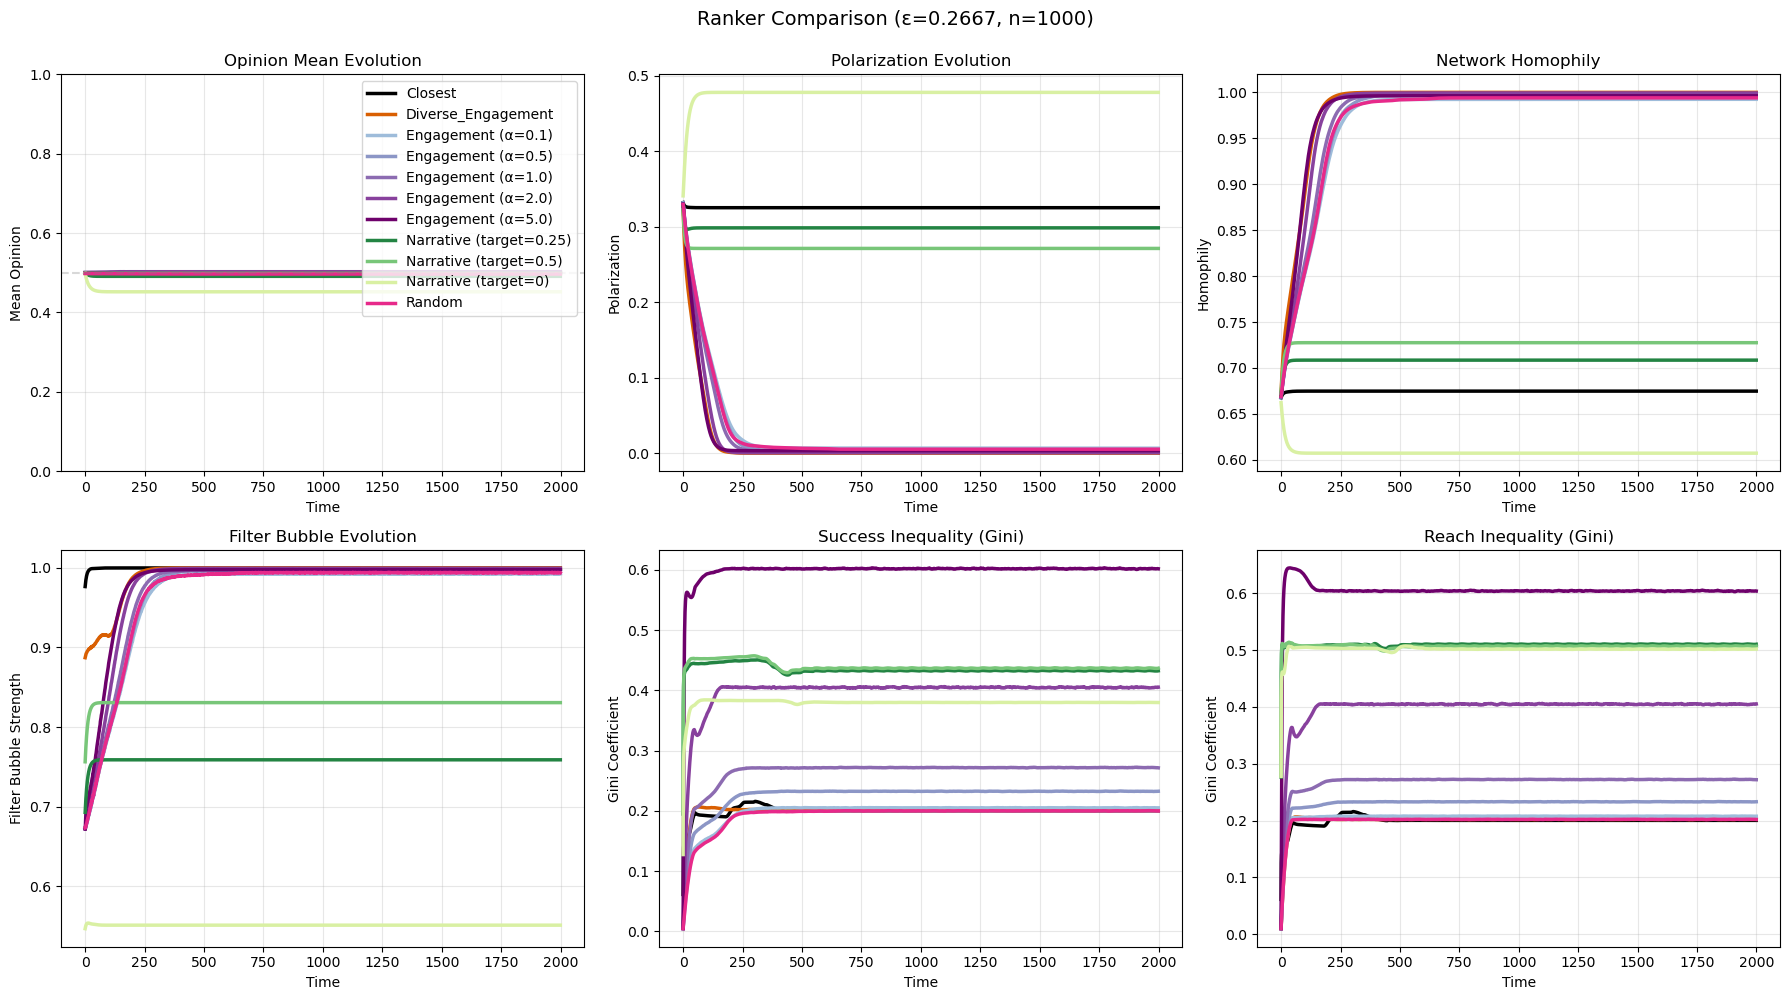


Found 11 rankers for epsilon=0.3111


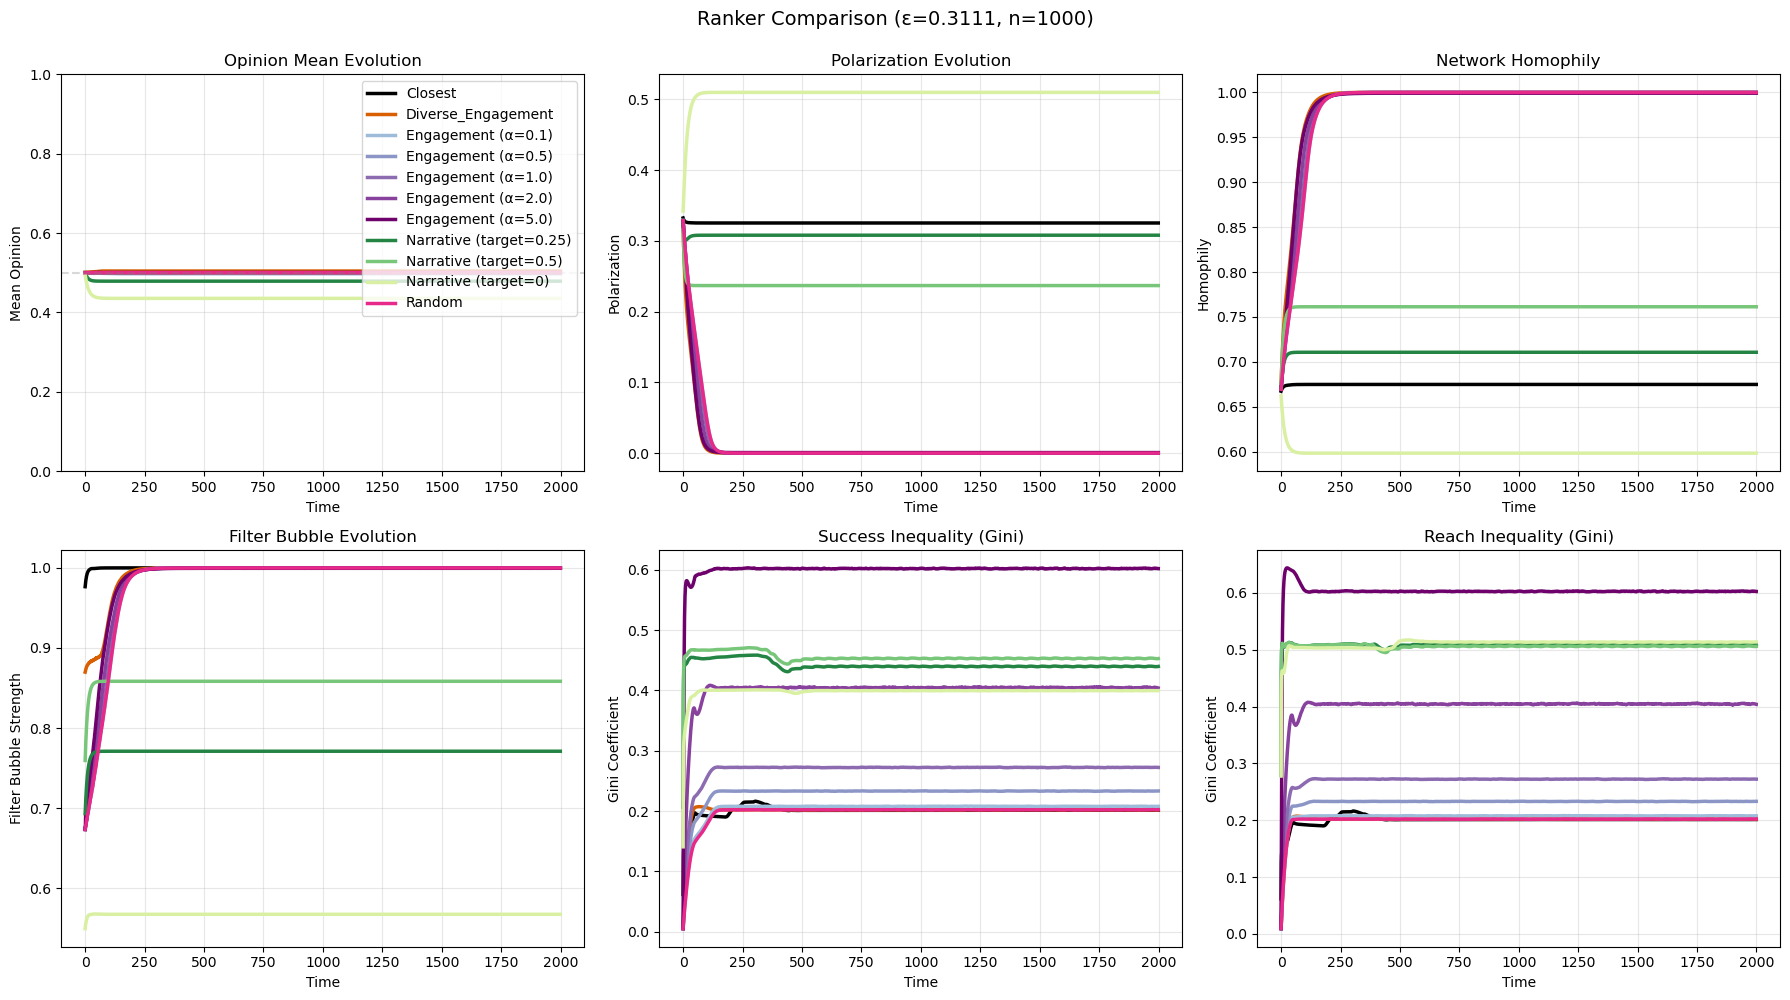


Found 11 rankers for epsilon=0.3556


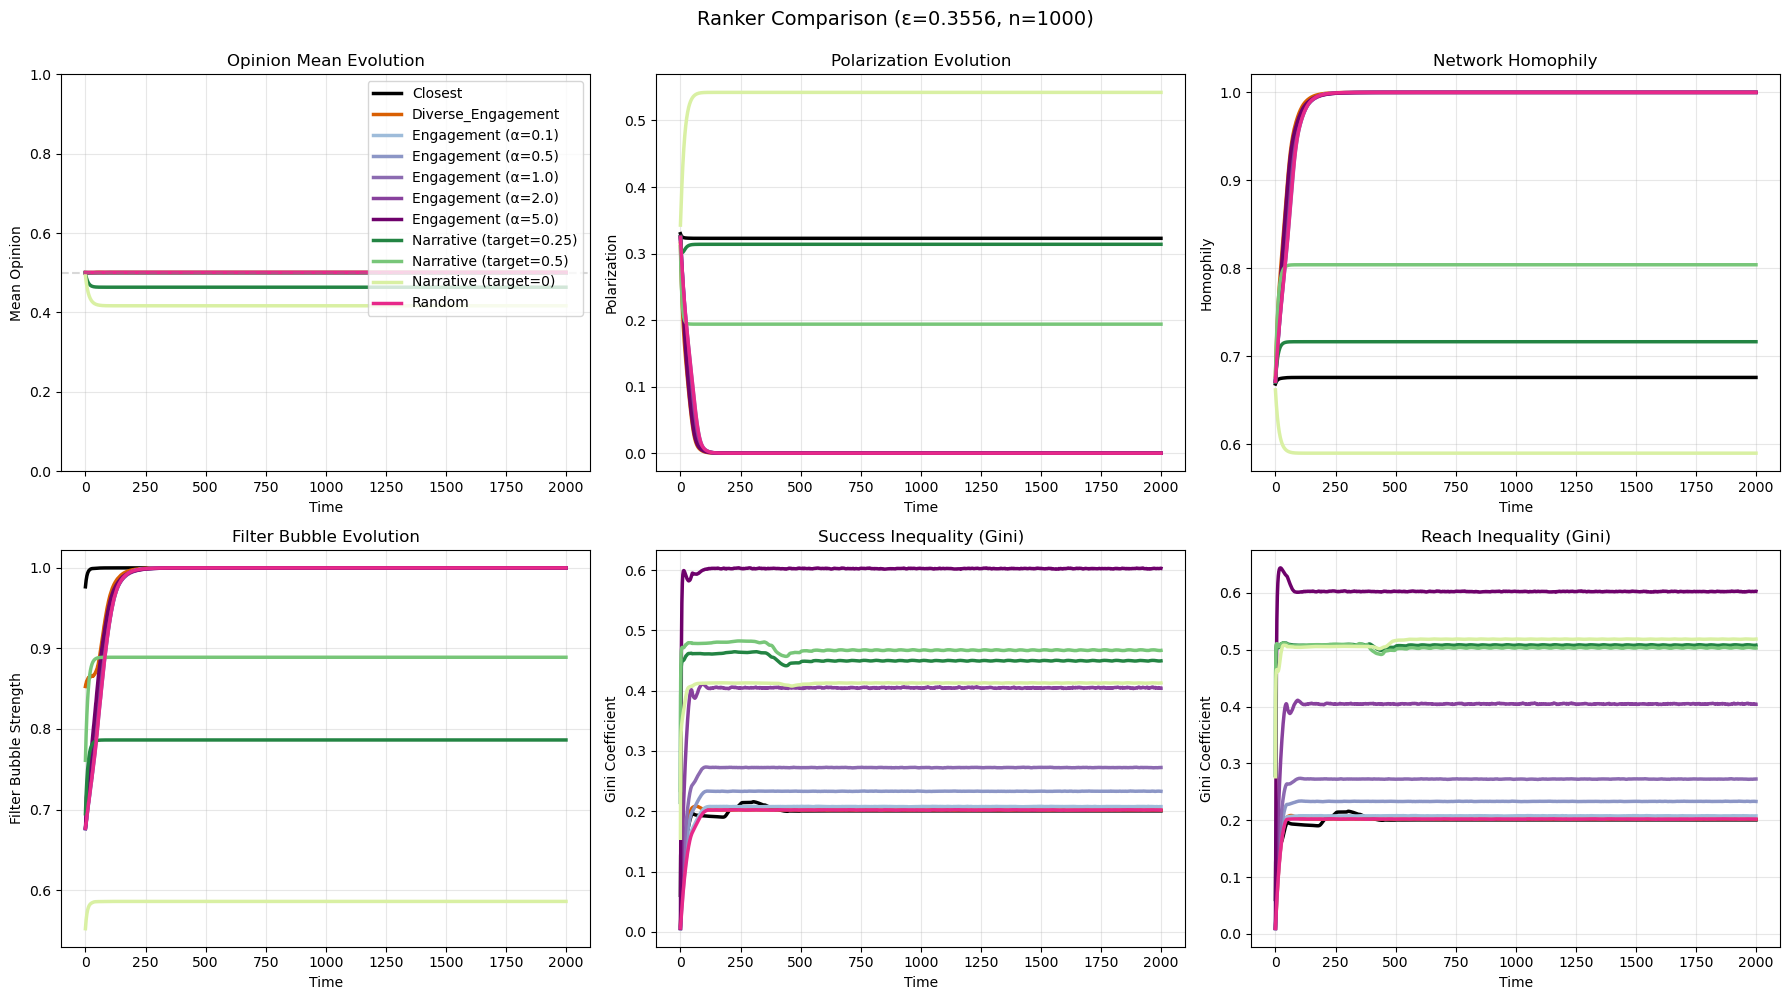


Found 11 rankers for epsilon=0.4


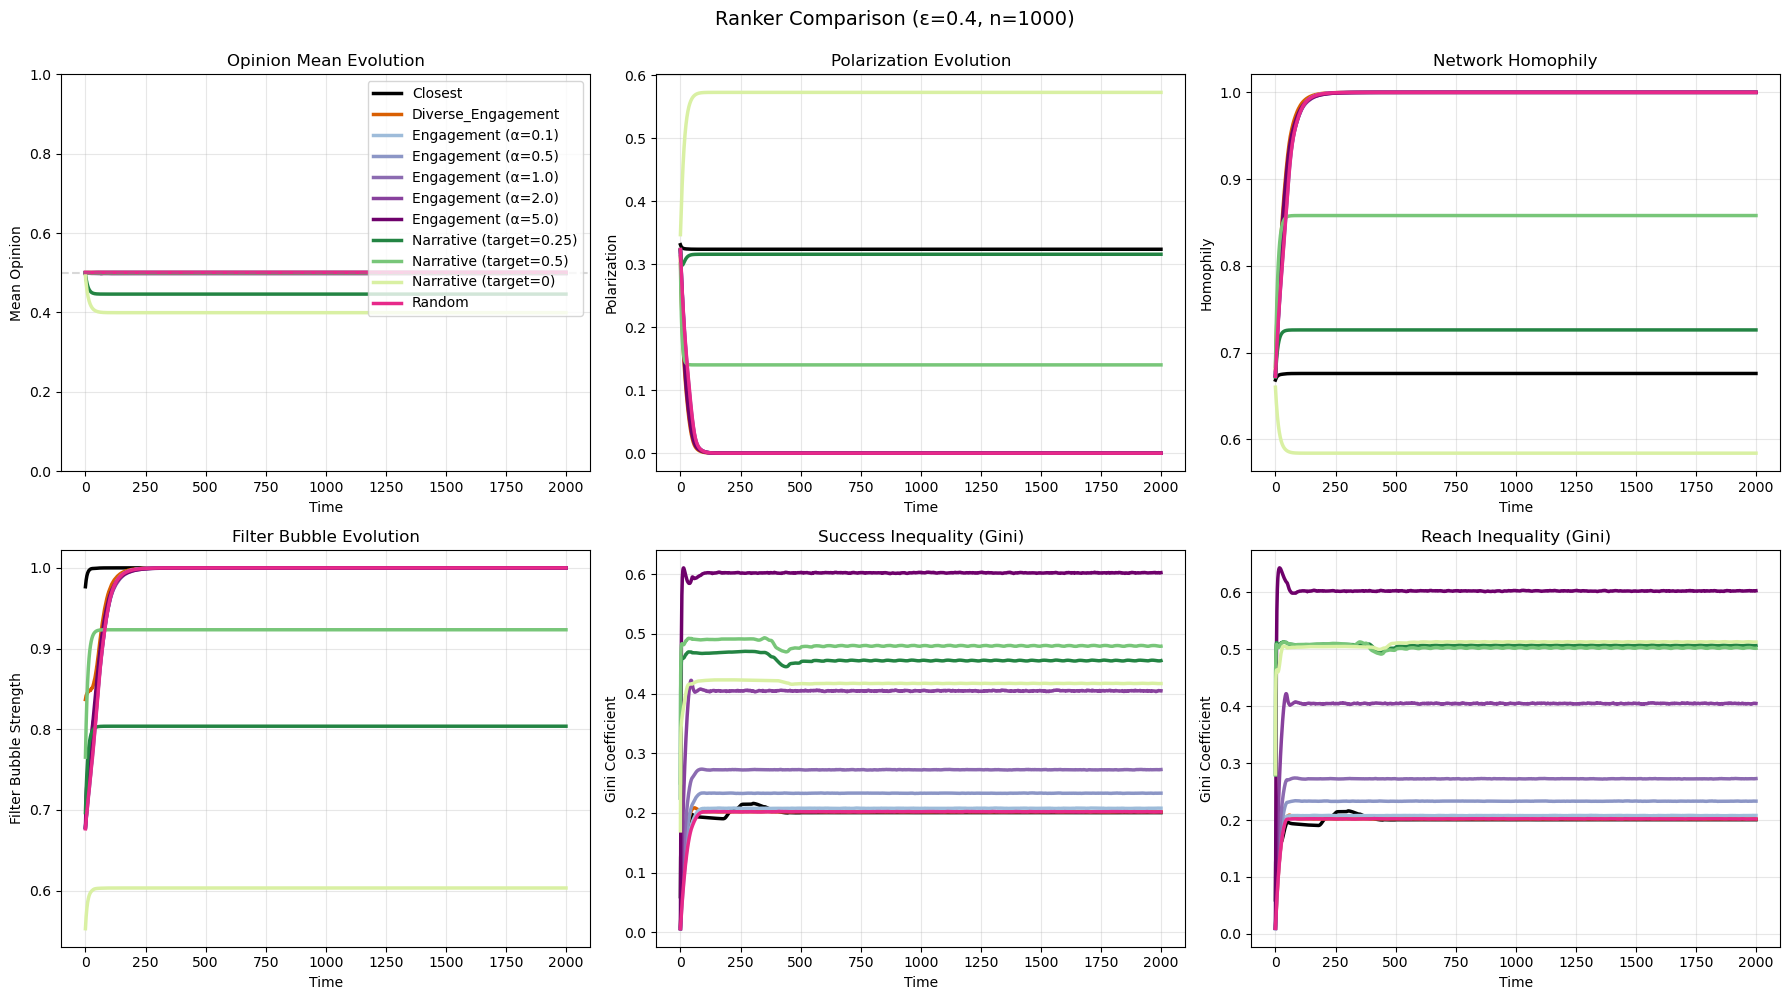

In [27]:
for i in range(10):
    # Pick an epsilon to visualize
    target_epsilon = epsilons[i]  # Change this to explore different epsilon values
    results_for_plot = []

    for key, (data, config) in all_results.items():
        epsilon = key[0]
        if abs(epsilon - target_epsilon) < 0.001:  # Floating point comparison
            results_for_plot.append([data, config])

    print(f"\nFound {len(results_for_plot)} rankers for epsilon={target_epsilon}")

    # Create comparison plot
    if len(results_for_plot) > 0:
        fig = plot_ranker_comparison_light(results_for_plot, colors=colors)
        plt.show()
    else:
        print(f"No results found for epsilon={target_epsilon}")